In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Define the repository URL and the local directory where you want to clone/pull the repository
repo_url = 'https://github.com/aakashvardhan/s10-residual-ocp.git'
local_dir = '/content/s10-residual-ocp'



# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

# !git clone 'https://github.com/aakashvardhan/s10-residual-ocp.git'

/content/s10-residual-ocp
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 2), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (5/5), 2.18 KiB | 1.09 MiB/s, done.
From https://github.com/aakashvardhan/s10-residual-ocp
   454ccde..bf4e81f  main       -> origin/main
Updating 454ccde..bf4e81f
Fast-forward
 notebooks/train-ocp-resnet.ipynb |  2 +-
 visualize.py                     | 88 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 2 files changed, 89 insertions(+), 1 deletion(-)
 create mode 100644 visualize.py


In [3]:
import sys
sys.path.append('/content/s10-residual-ocp')
sys.path.append('/content/s10-residual-ocp/models')

In [4]:
!pip install torch_lr_finder

  Using cached torch_lr_finder-0.2.1-py3-none-any.whl (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_6

In [5]:
from config import get_config
config = get_config()
from main import main
import torch
from utils import set_seeds
from setup_cifar10 import setup_cifar10
from torch_lr_finder import LRFinder
from models.custom_resnet import CustomResNet
from models.model_utils import model_summary, adam_optimizer
import torch.nn as nn
set_seeds()

In [6]:
config['epochs'] = 24
config['lr_scheduler'] = 'one_cycle'
config['lr'] = 0.05

In [ ]:
criterion = nn.CrossEntropyLoss()
train_data, test_data, train_loader, test_loader = setup_cifar10(config)
model = CustomResNet(config).to(config["device"])
model_summary(model, input_size=(3, 32, 32))
optimizer = adam_optimizer(model, config)
lr_finder = LRFinder(model, optimizer, criterion, device=config["device"])
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
print(lr_finder.history['lr'][-1])

In [ ]:
config['max_lr'] = lr_finder.history['lr'][-1]

CUDA Available? True


100%|██████████| 170498071/170498071 [00:05<00:00, 29586241.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
          Identity-2           [-1, 64, 32, 32]               0
          Identity-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
           Dropout-6           [-1, 64, 32, 32]               0
         ConvBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,728
         MaxPool2d-9          [-1, 128, 16, 16]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Drop

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.54E-02


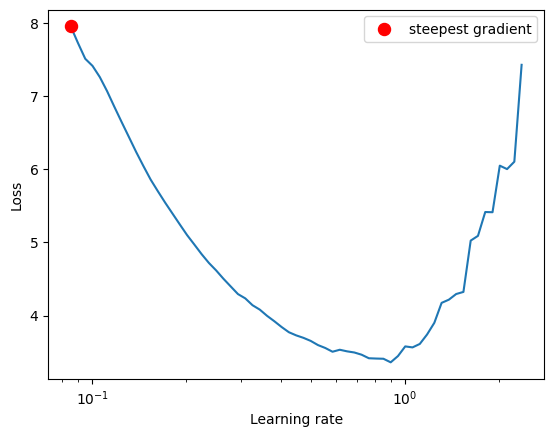

TypeError: cannot unpack non-iterable Axes object

In [7]:
lr = main(config, model, train_loader, test_loader, optimizer, criterion)

In [ ]:
import matplotlib.pyplot as plt
from utils import plt_fig
plt_fig()

In [ ]:
from visualize import show_misclassified_images, plt_misclassified_images

In [ ]:
misclass_imgs, misclass_targets, misclass_preds = show_misclassified_images(model, test_loader, config)
plt_misclassified_images(config, misclass_imgs, misclass_targets, misclass_preds)